In [2]:
%load_ext autoreload
%autoreload 2

import os
import re
import json
import numpy as np
import random
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from samples import load_all_output_files
from plot import *

from sklearn.metrics.pairwise import cosine_similarity

# Fixes problem with cutting off edges of plots
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load annotated stories (model-generated and human-written)

In [29]:
# Load the model-generated and human stories from the metric-annotated pickle files
# It may take a while, and you may need a lot of memory to load all of the files
story_data = load_all_output_files(data_dir='data/stories_metric_annotated')

100%|██████████| 87/87 [00:29<00:00,  1.20it/s]


In [30]:
# List the loaded data settings
for setting, data in story_data.items():
    print(setting)
    
HUMAN_SETTING = 'human.14693prompts'

fusion.01000prompts.00001topk
fusion.01000prompts.00002topk
fusion.01000prompts.00003topk
fusion.01000prompts.00004topk
fusion.01000prompts.00005topk
fusion.01000prompts.00006topk
fusion.01000prompts.00007topk
fusion.01000prompts.00008topk
fusion.01000prompts.00009topk
fusion.01000prompts.00010topk
fusion.01000prompts.00020topk
fusion.01000prompts.00030topk
fusion.01000prompts.00040topk
fusion.01000prompts.00050topk
fusion.01000prompts.00060topk
fusion.01000prompts.00070topk
fusion.01000prompts.00080topk
fusion.01000prompts.00090topk
fusion.01000prompts.00100topk
fusion.01000prompts.00200topk
fusion.01000prompts.00300topk
fusion.01000prompts.00400topk
fusion.01000prompts.00500topk
fusion.01000prompts.00600topk
fusion.01000prompts.00700topk
fusion.01000prompts.00800topk
fusion.01000prompts.00900topk
fusion.01000prompts.01000topk
fusion.01000prompts.02000topk
fusion.01000prompts.03000topk
fusion.01000prompts.04000topk
fusion.01000prompts.05000topk
fusion.01000prompts.06000topk
fusion.010

In [31]:
# For each setting, there are 1000 sample ids

print('\nSample ids:\n')
print(sorted(story_data['fusion.01000prompts.00300topk'].keys()))


Sample ids:

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [33]:
# For each sample id, there is one Sample (class defined in samples.py)

print('\nSample for sample id=395:\n')
story_data['fusion.01000prompts.00300topk'][395].display()


Sample for sample id=395:

PROMPT:
[ WP ] The year is <unk> . The air is no longer safe to breathe , <unk> of hundreds of genetically engineered <unk> viruses all capable of altering human DNA within seconds . A cult of clean air worshippers decides to venture out into the open and remove all their masks at once

STORY:
I was a 6 year old middle aged man with a big round head and big metal eyes . The kid was a 20 year old lad . The teacher would yell at my father and would run off to class and learn to love him . I always wonder if I 'll ever watch these kids play Call of Duty , we . <newline> <newline> After school we started learning to read our favorite book and book we learned . The book was still on a shelf . It was very short , but I tried her luck because I could n't create any bigger book . Shortly after I got home I was nearly ready to go home . I turned on my flashlight , began to write , and it started to take shape . <newline> <newline> The tiny thing was n't a big sized c

# Reconstruct per-word probabilities (for GPT2 datafiles)

In each Sample, the main dictionary contains two lists of the same length, `story_tokens` and `gen_probs`:
- `story_tokens` is a list of tokens generated by the model. For the Fusion Model, these are word-level tokens, and for GPT2-117, subword-level.
- `gen_probs`: is a list of the probabilities assigned to each token by the model.

We'd like to have comparable word-level probabilities for the GPT2-generated output. In this cell we reconstruct it by looking at whether the GPT2-generated tokens begin with space.

In [34]:
def get_perword_probs(sample, space_chars=['Ġ', 'Ċ']):
    """
    Gets the word-level probabilities and tokens from the BPE-level probabilities and tokens
    """
    bpe_probs = sample['gen_probs']
    bpe_tokens = sample['story_tokens']
    word_probs = []
    word_tokens = []
    curr_word_prob = None
    curr_word_token = None
    for idx, (p, t) in enumerate(zip(bpe_probs, bpe_tokens)):
        if t[0] in space_chars and curr_word_token!='':  # new word
            if curr_word_prob is not None:
                word_probs.append(curr_word_prob)  # stash the previous word
                word_tokens.append(curr_word_token)  # stash the previous word
            curr_word_prob = p
            curr_word_token = t[1:]
        else:  # continuing word
            if idx == 0:
                curr_word_prob = p
                curr_word_token = t
            else:
                curr_word_prob *= p
                curr_word_token += t
        if idx == len(bpe_probs)-1:  # at the end, stash the last word
            word_probs.append(curr_word_prob)
            word_tokens.append(curr_word_token)
    return word_probs, word_tokens


# Compute the per-word probs for GPT2-generated stories
# Store the per-word probs in 'gen_probs_word' and the word-level tokens in 'story_tokens_word'
print('Getting word-level probs and tokens for GPT2 generated stories...')
for setting in story_data.keys():
    if 'gpt2' not in setting:
        continue
    for prompt_key, sample in story_data[setting].items():
        sample['gen_probs_word'], sample['story_tokens_word'] = get_perword_probs(sample)
        if len(sample['gen_probs_word'])!=150:
            print('WARNING: for setting={}, prompt_key={}, the number of word-level tokens is {}'.format(setting, prompt_key, len(sample['gen_probs_word'])))
print('Done.')


# For symmetry, put the same in gen_probs_word and story_tokens_word for Fusion
print('Getting word-level probs and tokens for Fusion Model generated stories...')
for setting in story_data.keys():
    if 'fusion' not in setting:
        continue
    for sample in story_data[setting].values():
        sample['gen_probs_word'], sample['story_tokens_word'] = sample['gen_probs'], sample['story_tokens']
print('Done.')

Getting word-level probs and tokens for GPT2 generated stories...
Done.
Getting word-level probs and tokens for Fusion Model generated stories...
Done.


# Load teacher-forced data

This cell loads the teacher-forcing data from file and adjusts it to be consistent with the data for the generated samples.

In [35]:
# Load from file
fusion_tf_path = 'data/teacherforcing/fusion_teacherforced.10686examples.mixedlength.json' 
gpt2_tf_path = 'data/teacherforcing/gpt2_teacherforced.10686examples.mixedlength.json' 

def load_json(path):
    print('Loading {}...'.format(path))
    with open(path, 'r') as infile:
        data = json.load(infile)
        data = {int(k):v for k,v in data.items()}
    print('Done.')
    return data
    
fusion_tf_data = load_json(fusion_tf_path)
gpt2_tf_data = load_json(gpt2_tf_path)


# Make word-level probs for GPT2
print('Getting word-level probabilities for GPT2 teacher-forced data...')
for sample in gpt2_tf_data.values():
    sample['gen_probs_word'], sample['story_tokens_word'] = get_perword_probs(sample, space_chars=[' '])
print('Done')


# Make similar for Fusion Model
print('Getting word-level probabilities for Fusion Model teacher-forced data...')
for sample in fusion_tf_data.values():
    sample['gen_probs_word'], sample['story_tokens_word'] = sample['gen_probs'], sample['story_tokens']
print('Done')


# These files (both gpt2 and fusion) are NOT truncated to 150 words.
# For both, truncate gen_probs_word and story_tokens_word to 150 
# and throw out any examples that are < 150.
# Note: gen_probs and story_tokens remain the same (untruncated).

def truncate(tf_data, num_words=150):
    print("Have {} examples. Truncating stories to {} words and throwing out stories < {} words...".format(len(tf_data), num_words, num_words))
    keys = list(tf_data.keys())
    for key in keys:
        sample = tf_data[key]
        if len(sample['gen_probs_word']) < 150:
            del tf_data[key]
        sample['gen_probs_word'] = sample['gen_probs_word'][:150]
        sample['story_tokens_word'] = sample['story_tokens_word'][:150]
    print('Now have {} examples.'.format(len(tf_data)))
    return tf_data

print('Truncating to 150 words for Fusion Model teacher-forced data...')
fusion_tf_data = truncate(fusion_tf_data)
print('Done.')

print('Truncating to 150 words for GPT2 teacher-forced data...')
gpt2_tf_data = truncate(gpt2_tf_data)
print('Done.')

Loading data/teacherforcing/fusion_teacherforced.10686examples.mixedlength.json...
Done.
Loading data/teacherforcing/gpt2_teacherforced.10686examples.mixedlength.json...
Done.
Getting word-level probabilities for GPT2 teacher-forced data...
Done
Getting word-level probabilities for Fusion Model teacher-forced data...
Done
Truncating to 150 words for Fusion Model teacher-forced data...
Have 10686 examples. Truncating stories to 150 words and throwing out stories < 150 words...
Now have 10256 examples.
Done.
Truncating to 150 words for GPT2 teacher-forced data...
Have 10686 examples. Truncating stories to 150 words and throwing out stories < 150 words...
Now have 10241 examples.
Done.


# Function to save plots

In [36]:
SAVEDIR = 'plots'  # where you want plots to be saved

def save_plot(save_filename):
    save_filename = os.path.join(SAVEDIR, save_filename)
    print("Saving to %s..." % save_filename)
    plt.savefig(save_filename,
        dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
    print("Saved.")

### Plot pre-computed metrics (stored in Sample.metrics) vs k, for model-generated and human-written stories

Saving to plots/prompt_entity_usage_rate_vs_k.pdf...
Saved.
Saving to plots/pos_distinct_1_vs_k.pdf...
Saved.
Saving to plots/pos_distinct_2_vs_k.pdf...
Saved.
Saving to plots/pos_distinct_3_vs_k.pdf...
Saved.


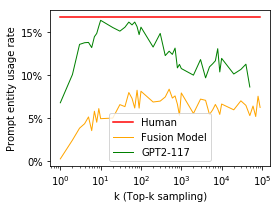

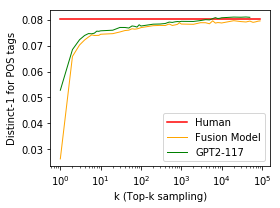

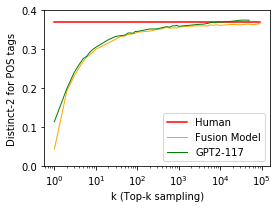

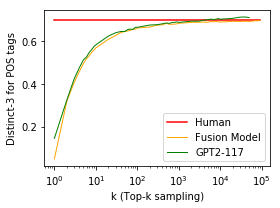

In [57]:
def get_mean(setting, metric_name):
    """Function to get mean value of a metric for a given model setting"""
    metric_values = [sample.metrics[metric_name] for sample in story_data[setting].values()]

    # For these metrics, some values are None, e.g. if all the nouns and verbs were not in the concretness dict
    # So filter them out from the mean computation
    if metric_name in ['mean_concreteness_noun', 'mean_concreteness_verb', 'prompt_entity_usage_rate']:
        metric_values = [v for v in metric_values if v is not None]
        
    return sum(metric_values)/len(metric_values)

def plot_metric_vs_k(metric_name, ylabel, figsize=(4,3), yaxisrange=None, yticks=None, ytick_format=None, scaling_factor=None, legend_loc='best'):
    """Function to plot the given metric vs k, for all model settings and human"""
    
    # Set up plot
    figure = plt.figure(figsize=figsize)
    fig = plt.gca()
    
    # X axis settings
    fig.set_xlabel('k (Top-k sampling)')
    plt.xscale('log')
    
    # Y axis settings
    fig.set_ylabel(ylabel)
    if yaxisrange is not None:
        fig.set_ylim(yaxisrange)
    if ytick_format is not None:
        fig.yaxis.set_major_formatter(mtick.FormatStrFormatter(ytick_format))
    if yticks is not None:
        plt.yticks(yticks)
    
    # Plot human line
    human_val = get_mean(HUMAN_SETTING, metric_name)
    if scaling_factor is not None:
        human_val = human_val * scaling_factor
    model_name = 'human'
    fig.plot([MIN_K, MAX_K], [human_val, human_val], label=MODEL2LEGENDNAME[model_name], color=MODEL2COLOR[model_name], linestyle=MODEL2LINESTYLE[model_name], linewidth=MODEL2LINEWIDTH[model_name])
    
    # Plot Fusion Model and GPT2-117 lines
    for model_name in 'fusion', 'gpt2':
        settings = sorted([setting for setting in story_data.keys() if model_name in setting])
        k_vals = [int(setting.split('.')[2][:5]) for setting in settings]
        metric_vals = [get_mean(setting, metric_name) for setting in settings]
        if scaling_factor is not None:
            metric_vals = [val*scaling_factor for val in metric_vals]
        fig.plot(k_vals, metric_vals, label=MODEL2LEGENDNAME[model_name], color=MODEL2COLOR[model_name], linestyle=MODEL2LINESTYLE[model_name], linewidth=MODEL2LINEWIDTH[model_name])
        
    # Add legend
    fig.legend(loc=legend_loc)
    
    # Save
    save_plot('%s_vs_k.pdf' % metric_name)
    
    
# plot_metric_vs_k('arora_mean_pairwise_sim', 'Story-prompt sent sim')
# plot_metric_vs_k('copied_1gram_frac', '% Story unigrams in prompt', scaling_factor=100, ytick_format='%.0f%%')
# plot_metric_vs_k('copied_2gram_frac', '% Story bigrams in prompt', scaling_factor=100, ytick_format='%.0f%%', yaxisrange=[0, 5])
# plot_metric_vs_k('copied_3gram_frac', '% Story trigrams in prompt', scaling_factor=100, ytick_format='%.1f%%')
# plot_metric_vs_k('num_unique_entities', '# Unique named entities per story', yaxisrange=[0, 4])
# plot_metric_vs_k('distinct_1', 'Distinct-1', yaxisrange=[0, 0.65])
# plot_metric_vs_k('distinct_2', 'Distinct-2', yaxisrange=[0,1])
# plot_metric_vs_k('distinct_3', 'Distinct-3', yaxisrange=[0,1])
# plot_metric_vs_k('mean_log_unigramprob', 'Mean log unigram prob')
# plot_metric_vs_k('stopwords_frac', '% Words that are stopwords', yaxisrange=[58, 76], scaling_factor=100, ytick_format='%.0f%%')
# plot_metric_vs_k('mean_sent_len', 'Mean sent len (# words)', yaxisrange=[12, 15.5], yticks=range(12, 16))
# plot_metric_vs_k('mean_concreteness_noun', 'Mean noun concreteness')
# plot_metric_vs_k('mean_concreteness_verb', 'Mean verb concreteness')
plot_metric_vs_k('prompt_entity_usage_rate', 'Prompt entity usage rate', scaling_factor=100, ytick_format='%.0f%%')
plot_metric_vs_k('pos_distinct_1', 'Distinct-1 for POS tags')
plot_metric_vs_k('pos_distinct_2', 'Distinct-2 for POS tags', yaxisrange=[0,0.4])
plot_metric_vs_k('pos_distinct_3', 'Distinct-3 for POS tags')

## Function to plot other values vs k, for model-generated and human-written stories

In [54]:
def plot_value_vs_k(value_fn, figsize, ylabel, ylim=None, ytick_format=None, yticks=None, legend_loc='best'):
    """
    Function to plot the given value vs k, for all model settings and human.
    value_fn should be a function that maps from a setting name (e.g. 'gpt2.01000prompts.03000topk') to a float.
    """
    
    # Set up plot
    figure = plt.figure(figsize=figsize)
    fig = plt.gca()
    
    # X axis settings
    fig.set_xlabel('k (Top-k sampling)')
    plt.xscale('log')
    
    # Y axis settings
    fig.set_ylabel(ylabel)
    if ylim:
        fig.set_ylim(ylim)
    if ytick_format:
        fig.yaxis.set_major_formatter(mtick.FormatStrFormatter(ytick_format))
    if yticks is not None:
        plt.yticks(yticks)
    
    # Plot human line
    human_val = value_fn(HUMAN_SETTING)
    model_name = 'human'
    fig.plot([MIN_K, MAX_K], [human_val, human_val], label=MODEL2LEGENDNAME[model_name], color=MODEL2COLOR[model_name], linestyle=MODEL2LINESTYLE[model_name], linewidth=MODEL2LINEWIDTH[model_name])
    
    # Plot Fusion Model and GPT2-117 lines
    for model_name in 'fusion', 'gpt2':
        settings = sorted([setting for setting in story_data.keys() if model_name in setting])
        k_vals = [int(setting.split('.')[2][:5]) for setting in settings]
        metric_vals = [value_fn(setting) for setting in settings]
        fig.plot(k_vals, metric_vals, label=MODEL2LEGENDNAME[model_name], color=MODEL2COLOR[model_name], linestyle=MODEL2LINESTYLE[model_name], linewidth=MODEL2LINEWIDTH[model_name])
    
    # Add legend
    fig.legend(loc=legend_loc)
    

# Plot POS tag usage

plotting VERB...
Saving to plots/postag_VERB_usage.pdf...
Saved.
plotting PUNCT...
Saving to plots/postag_PUNCT_usage.pdf...
Saved.
plotting NOUN...
Saving to plots/postag_NOUN_usage.pdf...
Saved.
plotting DET...
Saving to plots/postag_DET_usage.pdf...
Saved.
plotting ADP...
Saving to plots/postag_ADP_usage.pdf...
Saved.
plotting PRON...
Saving to plots/postag_PRON_usage.pdf...
Saved.
plotting ADV...
Saving to plots/postag_ADV_usage.pdf...
Saved.
plotting ADJ...
Saving to plots/postag_ADJ_usage.pdf...
Saved.
plotting CCONJ...
Saving to plots/postag_CCONJ_usage.pdf...
Saved.
plotting PROPN...
Saving to plots/postag_PROPN_usage.pdf...
Saved.
plotting PART...
Saving to plots/postag_PART_usage.pdf...
Saved.
plotting NUM...
Saving to plots/postag_NUM_usage.pdf...
Saved.
plotting INTJ...
Saving to plots/postag_INTJ_usage.pdf...
Saved.
plotting X...
Saving to plots/postag_X_usage.pdf...
Saved.
plotting SYM...
Saving to plots/postag_SYM_usage.pdf...
Saved.


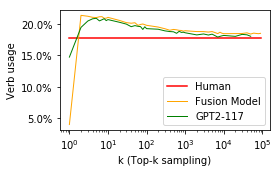

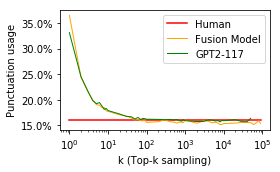

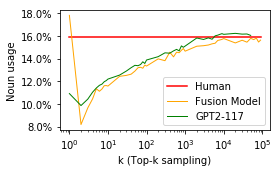

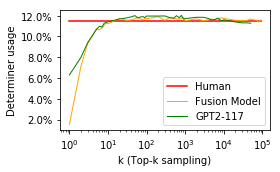

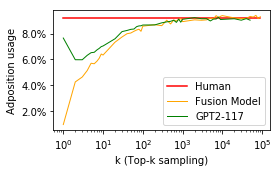

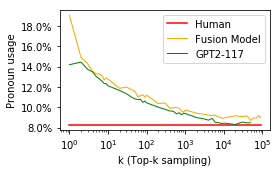

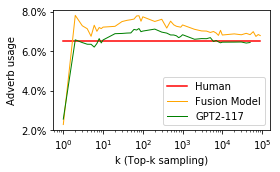

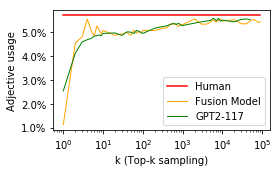

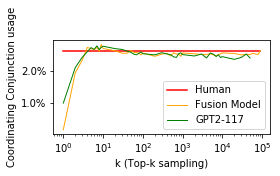

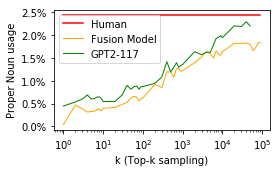

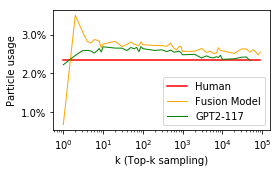

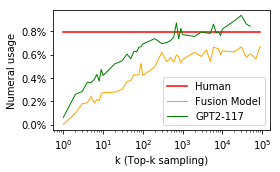

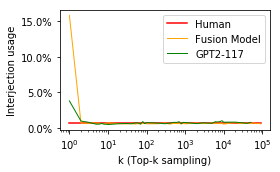

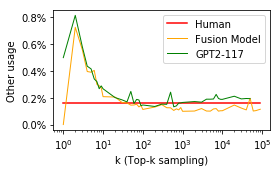

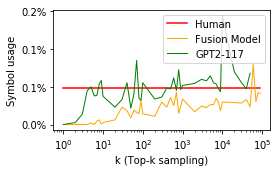

In [56]:
TAG2NAME = {
    'VERB': 'verb',
    'PUNCT': 'punctuation', 
    'NOUN': 'noun',
    'DET': 'determiner', 
    'ADP': 'adposition',
    'PRON': 'pronoun',
    'ADV': 'adverb',
    'ADJ': 'adjective',
    'CCONJ': 'coordinating conjunction',
    'PROPN': 'proper noun', 
    'PART': 'particle',
    'NUM': 'numeral', 
    'INTJ': 'interjection',
    'X': 'other',
    'SYM': 'symbol',
}


def get_pos_ngram_probdist(setting, n):
    """
    Return a dictionary (a Counter) that maps each POS ngram to its probability,
    computed over all the samples for this setting
    """
    pos_ngram_counter = Counter()
    key2sample = story_data[setting]
    for sample in key2sample.values():
        ngrams = sample.cache['pos_{}grams_story'.format(n)]
        pos_ngram_counter.update(ngrams)
    total = sum(pos_ngram_counter.values())
    pos_ngram_counter = Counter({k:v/total for k,v in pos_ngram_counter.items()})
    return pos_ngram_counter


def get_postag_usage(setting, POS_tag):
    """
    Compute the probability distribution for POS tags (i.e. POS unigrams) over all samples for this setting.
    Return the given POS_tag's percentage share.
    """
    model_pos_1gram_probdist = get_pos_ngram_probdist(setting, 1)
    return model_pos_1gram_probdist[POS_tag] * 100


for pos_tag, tag_name in TAG2NAME.items():
    print('plotting {}...'.format(pos_tag))
    plot_value_vs_k(lambda setting: get_postag_usage(setting, pos_tag), figsize=(4, 2.5), ylabel='{} usage'.format(TAG2NAME[pos_tag].title()), ytick_format='%.1f%%')
    save_plot('postag_{}_usage.pdf'.format(pos_tag))


# Plot word probs (models and human) for a single example

Saving to plots/fusion_p_over_story.pdf...
Saved.
Saving to plots/gpt2_p_over_story.pdf...
Saved.
Saving to plots/human_p_over_story.pdf...
Saved.

PROMPT:
[ IP ] Lava Ruins


FUSION MODEL GENERATING (fusion.01000prompts.00002topk):
I had never seen a man so young before . I had never seen him before , but he had always seemed to be a man of a man . He was young , and he was young . He was a man of a man , and a man who was young , and a man who was young . He had a man who was young , and he was young , and he was young , but he had a man who was young , and he had a man that was young , and he was young , and he was young , and he was young , and he was young , and he was young , and he was young , and he was young , and he had a man who was young , and he was young , and he was young

GPT2-117 GENERATING (gpt2.01000prompts.00002topk):
I 've always been a man of the people . I 've always been a strong man . <newline> <newline> I 've always been a strong man . I was born in the city ,

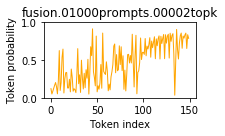

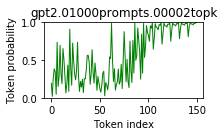

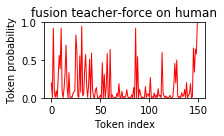

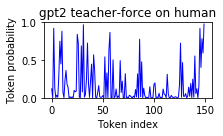

In [59]:
# Note, in this cell we use gen_probs_word which is the word-level probabilities 
# for the first 150 words (same for Fusion Model and GPT2-117)

def plot_prob_over_story(prob_seq, figsize, color, title):
    """Plot the prob sequence over time"""
    figure = plt.figure(figsize=figsize)
    fig = plt.gca()
    fig.set_title(title)
    fig.set_xlabel('Token index')
    fig.set_ylabel('Token probability')
    fig.set_ylim([0,1])
    plt.yticks([0,0.5,1])
    fig.plot(prob_seq, color=color, linewidth=1)


def plot_prob_sidebyside(prompt_key, fusion_gen_setting, gpt2_gen_setting, fusion_tf_data, gpt2_tf_data, num_steps, figsize=FIGSIZE_SMALL):
    
    # Get the sequences to plot
    fusion_gen_prob = story_data[fusion_gen_setting][prompt_key]['gen_probs_word'][:num_steps]
    gpt2_gen_prob = story_data[gpt2_gen_setting][prompt_key]['gen_probs_word'][:num_steps]
    fusion_tf_prob = fusion_tf_data[prompt_key]['gen_probs_word'][:num_steps]
    gpt2_tf_prob = gpt2_tf_data[prompt_key]['gen_probs_word'][:num_steps]
    
    # Plot
    plot_prob_over_story(fusion_gen_prob, figsize=figsize, color=MODEL2COLOR['fusion'], title=fusion_gen_setting)
    save_plot('fusion_p_over_story.pdf')
    plot_prob_over_story(gpt2_gen_prob, figsize=figsize, color=MODEL2COLOR['gpt2'], title=gpt2_gen_setting)
    save_plot('gpt2_p_over_story.pdf')
    plot_prob_over_story(fusion_tf_prob, figsize=figsize, color='red', title='fusion teacher-force on human')
    save_plot('human_p_over_story.pdf')
    plot_prob_over_story(gpt2_tf_prob, figsize=figsize, color='blue', title='gpt2 teacher-force on human')
    
    # Show text
    prompt = gpt2_tf_data[prompt_key]['prompt_text']
    human_story = gpt2_tf_data[prompt_key]['story_text']
    
    print('\nPROMPT:')
    print(prompt)
    print('\nFUSION MODEL GENERATING ({}):'.format(fusion_gen_setting))
    print(story_data[fusion_gen_setting][prompt_key]['story_text'])
    print('\nGPT2-117 GENERATING ({}):'.format(gpt2_gen_setting))
    print(story_data[gpt2_gen_setting][prompt_key]['story_text'])
    print('\nHUMAN TEXT:')
    print(human_story)
    
    
gpt_setting = 'gpt2.01000prompts.00002topk'
fusion_setting = 'fusion.01000prompts.00002topk'

prompt_key = 155
plot_prob_sidebyside(prompt_key, fusion_setting, gpt_setting, fusion_tf_data, gpt2_tf_data, 150, figsize=(3.2, 2))

# Plot word probabilities increasing over time (generation vs teacher-forcing)

Saving to plots/increasing_tokenprob_gpt2.pdf...
Saved.
Saving to plots/increasing_tokenprob_fusion.pdf...
Saved.


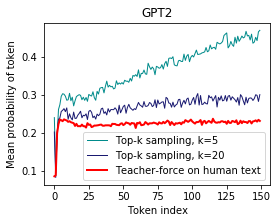

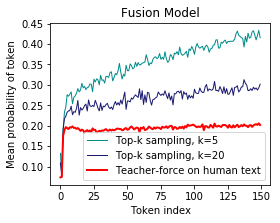

In [65]:
# Note, in this cell we use gen_probs_word which is the word-level probabilities 
# for the first 150 words (same for Fusion Model and GPT2-117)

def get_pertoken_mean_prob(key2sample, num_steps=150):
    """
    Given key2sample, which is data (either from generation or teacher-forcing) 
    that includes per-word probabilities in gen_probs_word, return a np array of length num_steps, 
    where each value is the mean prob on that step.
    """
    prob_sums = np.zeros(num_steps)  # will be a list length num_steps, containing the probabilities summed over all samples
    num_samples = 0
    for sample in key2sample.values():
        word_probs = sample['gen_probs_word']  # list of floats
        if len(word_probs) < num_steps:  # if this example has fewer than num_steps (150) steps, discard
            continue
        word_probs = np.array(word_probs[:num_steps])  # truncate to first num_steps
        prob_sums += word_probs  # add to the total
        num_samples += 1 
    mean_probs = prob_sums/num_samples
    return mean_probs
        

def make_increasing_tokenprob_plot(tf_datas, tf_labels, tf_colors, gen_settings, gen_colors, title, figsize=(4,3.2), num_steps=150):
    
    # Get the values to plot
    tf_vals = [get_pertoken_mean_prob(tf_data, num_steps) for tf_data in tf_datas]
    gen_vals = [get_pertoken_mean_prob(story_data[gen_setting], num_steps) for gen_setting in gen_settings]

    # Get the top k vals for the generation settings
    kvals = [int(gen_setting.split('.')[2][:5]) for gen_setting in gen_settings]
    
    # Set up plot
    figure = plt.figure(figsize=figsize)
    fig = plt.gca()
    
    # X axis settings
    fig.set_xlabel('Token index')
    
    # Y axis settings
    fig.set_ylabel('Mean probability of token')
        
    # Plot 
    x_vals = range(num_steps)
    for (gen_setting, gen_val, kval, col) in zip(gen_settings, gen_vals, kvals, gen_colors):
        model_name = 'Fusion Model' if 'fusion' in gen_setting else 'GPT2-117'
        fig.plot(x_vals, gen_val, label='Top-k sampling, k={}'.format(kval), color=col, linewidth=1)
    for (tf_val, tf_label, tf_col) in zip(tf_vals, tf_labels, tf_colors):
        fig.plot(x_vals, tf_val, label='Teacher-force on human text', color=tf_col, linewidth=2)
        
    # Add title and legend
    fig.set_title(title)
    fig.legend(loc='best')
    


make_increasing_tokenprob_plot(tf_datas=[gpt2_tf_data], 
                               tf_labels=['GPT2-117'],
                               tf_colors=['red'],
                               gen_settings=['gpt2.01000prompts.00005topk', 'gpt2.01000prompts.00020topk'], 
                               gen_colors=['darkcyan', 'midnightblue'],
                               title='GPT2')

save_plot('increasing_tokenprob_gpt2.pdf')

make_increasing_tokenprob_plot(tf_datas=[fusion_tf_data], 
                               tf_labels=['Fusion Model'],
                               tf_colors=['red'],
                               gen_settings=['fusion.01000prompts.00005topk', 'fusion.01000prompts.00020topk'], 
                               gen_colors=['darkcyan', 'midnightblue'],
                               title='Fusion Model')

save_plot('increasing_tokenprob_fusion.pdf')

# Plot average log P(story) vs k

Saving to plots/fusion_story_logprob_vs_k.pdf...
Saved.
Saving to plots/gpt2_story_logprob_vs_k.pdf...
Saved.


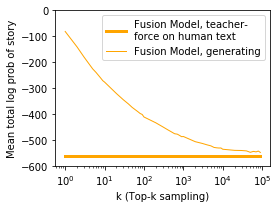

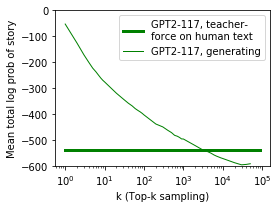

In [67]:
def get_mean_story_logprob(key2sample):
    """
    For each sample, compute the total log probability of the story (according to the model).
    Here "story" means first 150 words. 
    Return the mean over all samples. 
    """
    vals = []
    for sample in key2sample.values():
        prob_seq = sample['gen_probs_word']   # this should already be length 150
        if len(prob_seq) != 150:
            print('WARNING: this sample has a prob_seq of length {}'.format(len(prob_seq)))
        logprob = np.sum(np.log(prob_seq))
        vals.append(logprob)
    return np.mean(vals)


def plot_mean_storylogprob_vs_k(model_name, figsize, ylabel, ylim=None, ytick_format=None):
    
    # Set up plot
    figure = plt.figure(figsize=figsize)
    fig = plt.gca()
    
    # X axis settings
    fig.set_xlabel('k (Top-k sampling)')
    plt.xscale('log')
    
    # Y axis settings
    fig.set_ylabel(ylabel)
    fig.set_ylim(ylim)
    
    # Plot teacher-forced line
    modelname2tfdata = {'gpt2': gpt2_tf_data, 'fusion': fusion_tf_data}
    tf_val = get_mean_story_logprob(modelname2tfdata[model_name])
    fig.plot([MIN_K, MAX_K], [tf_val, tf_val], label='{}, teacher-\nforce on human text'.format(MODEL2LEGENDNAME[model_name]), color=MODEL2COLOR[model_name], linewidth=3)
    
    # Plot generation values for all k
    settings = sorted([setting for setting in story_data.keys() if model_name in setting])
    k_vals = [int(setting.split('.')[2][:5]) for setting in settings]
    gen_vals = [get_mean_story_logprob(story_data[setting]) for setting in settings]
    fig.plot(k_vals, gen_vals, label='{}, generating'.format(MODEL2LEGENDNAME[model_name]), color=MODEL2COLOR[model_name], linestyle=MODEL2LINESTYLE[model_name], linewidth=1)
    
    # Add legend
    fig.legend(loc='best')
    
    # Save
    save_plot('{}_story_logprob_vs_k.pdf'.format(model_name))
    

plot_mean_storylogprob_vs_k('fusion', figsize=(4,3), ylabel='Mean total log prob of story', ylim=[-600, 0])
plot_mean_storylogprob_vs_k('gpt2', figsize=(4,3), ylabel='Mean total log prob of story', ylim=[-600, 0])